In [1]:
import os
from osgeo import gdal
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyproj import Proj, Geod

%load_ext autoreload
%autoreload 2

## HPC with ames

In [ ]:
WORK IN THE PROJECTS FOLDER!

wget https://ot-data3.sdsc.edu/appRasterSelectService1740605649622-1111472584/rasters_COP30.tar.gz

unzip it

dem_geoid --geoid egm2008 --reverse-adjustment output_hh.tif -o dem

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"

mapproject -t rpc      --threads 60                   \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  dem-adj.tif ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.TIF ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.XML ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.map.TIF
 
mapproject -t rpc   --threads 60       \
  --tr 0.5                                  \
  --t_srs "$proj"                           \
  dem-adj.tif ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.TIF ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.XML ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.map.TIF
 
parallel_stereo -t dg   --processes 100 --corr-memory-limit-mb   256   \
  --alignment-method none \
  --stereo-algorithm asp_mgm        \
  --subpixel-mode 3  ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.map.TIF \
    ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.map.TIF \
    ./20240116stereo/24JAN16050550-P1BS-050278578010_01_P002.XML \
    ./20240116stereo/24JAN16050706-P1BS-050278578010_01_P001.XML \
    run_post/run dem-adj.tif

proj="+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs"
point2dem --t_srs "$proj" --tr 0.5 run_post/run-PC.tif --orthoimage run_post/run-L.tif



## Stereo WV 2 m

In [16]:
from osgeo import gdal

rewrite = False

flist = ['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/OrthosWith2mDem/24JAN16050706-P1BS-050278578010_01_P001-ortho.tif',
            '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/OrthosWith2mDem/25FEB26080048-P1BS-050299533010_01_P001-ortho.tif']

flist = ['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/DEMs/XizangDEM_2m_20240116_WV2Strip.tif',
         '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/DEMs/XizangDEM_2m_20250126_WV2Strip.tif']


ullr = [548030.4,3212449.8,561443.2,3150925.5] # Upper Left, lower right coordinates

for im in flist:
    if rewrite == True:
        with gdal.Warp(
        f'{im[:-4]}-cropped.tif',
        im,
        srcSRS='EPSG:32645',
        dstSRS='EPSG:32645',
        outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
        srcNodata=-9999,
        dstNodata=0,
        format='GTiff',
        outputType=gdal.GDT_Int16,
        resampleAlg='near',
        xRes=2.0,
        yRes=2.0  # Use a positive value for yRes
        ) as im:
            im.FlushCache()



In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism 24JAN16050706-P1BS-050278578010_01_P001-ortho-cropped.tif 25FEB26080048-P1BS-050299533010_01_P001-ortho-cropped.tif CorMin=0.1 Dequant=false DirMEC='MEC_Tibet2mOrtho/' &
nohup taskset -c 0-64 mm3d Mm2dPosSism XizangDEM_2m_20240116_WV2Strip-cropped.tif XizangDEM_2m_20250126_WV2Strip-cropped.tif CorMin=0.1 Dequant=false DirMEC='MEC_Tibet2mDEM/' &


TypeError: unhashable type: 'list'

In [15]:
tt.micmacPostProcessing(folder='/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/',
                         prefiles=['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/OrthosWith2mDem/25FEB26080048-P1BS-050299533010_01_P001-ortho-cropped.tif',
                                   '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/OrthosWith2mDem/24JAN16050706-P1BS-050278578010_01_P001-ortho-cropped.tif'],
                         outprefix='/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/')

Nodata value for mask: 0.0
Setting nodata value to -9999
Saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/NSmicmac.tif
Saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/EWmicmac.tif
Saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/Correlmicmac.tif


In [18]:
tt.micmacPostProcessing(folder='/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/',
                         prefiles=['/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/DEMs/XizangDEM_2m_20250126_WV2Strip-cropped.tif',
                                    '/Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/DEMs/XizangDEM_2m_20240116_WV2Strip-cropped.tif'],
                         outprefix='/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/')

Nodata value for mask: 0.0
Setting nodata value to -9999
Saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/NSmicmac.tif
Saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/EWmicmac.tif
Saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/Correlmicmac.tif


In [59]:
from osgeo_utils import gdal_calc, gdal_edit

def micmacAnyStack(infolderlist, outfolder):
    """
    Creates NS, EW stacked maps, weighted by correlation score, while handling NoData values.
    
    Each folder in infolderlist should contain:
      - EWmicmac.tif
      - NSmicmac.tif
      - Correlmicmac.tif
    
    Parameters:
        - infolderlist: List of folders containing input displacement maps
        - outfolder: Output directory for stacked maps
        - nodata_value: NoData value to use (if None, it will be inferred from the first file)
    """
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    
    nodata_value = -9999  # NoData value 

    print(f"Using NoData value: {nodata_value}")

    # Define displacement components
    components = ["NS", "EW"]

    for comp in components:
        # Construct file lists dynamically
        disp_files = [os.path.join(folder, f"{comp}micmac.tif") for folder in infolderlist]
        corr_files = [os.path.join(folder, "Correlmicmac.tif") for folder in infolderlist]

        # Build weighted sum formula
        # eg for 4 input: 'A*E/(E+F+G+H)+B*F/(E+F+G+H)+C*G/(E+F+G+H)+D*H/(E+F+G+H)'
        calc_expr = "+".join([f"(A{i}*C{i})/({"+".join([f"C{j}" for j in range(len(infolderlist))])})" for i in range(len(infolderlist))])
        print(calc_expr)

        # Prepare argument list for gdal_calc.py
        calc_args = {f"A{i}": disp_files[i] for i in range(len(infolderlist))}
        calc_args.update({f"C{i}": corr_files[i] for i in range(len(infolderlist))})
        calc_args["calc"] = calc_expr
        calc_args["outfile"] = os.path.join(outfolder, f"{comp}dispStacked.tif")
        calc_args["NoDataValue"] = nodata_value

        # Run gdal_calc
        gdal_calc.Calc(**calc_args)

        print(calc_args)

        # nodata is reset to another value, change:
        #ds = gdal.Open(os.path.join(outfolder, f"{comp}dispStacked.tif"), gdal.GA_Update)
        #band = ds.GetRasterBand(1)
        #band.SetNoDataValue(-9999)
        #band.FlushCache()
        #ds = None

    # Compute sum of correlation scores, ignoring NoData values
    calc_expr_corr = "+".join([f"A{i}" for i in range(len(infolderlist))])
    gdal_calc.Calc(
        calc=calc_expr_corr,
        **{f"A{i}": corr_files[i] for i in range(len(infolderlist))},
        outfile=os.path.join(outfolder, "CorreldispStacked.tif"),
        NoDataValue=nodata_value
    )

    # nodata is reset to another value, change:
    #ds = gdal.Open(os.path.join(outfolder, "CorreldispStacked.tif"), gdal.GA_Update)
    #band = ds.GetRasterBand(1)
    #band.SetNoDataValue(-9999)
    #band.FlushCache()
    #ds = None


    return "Done!"

In [60]:
infolderlist = [
    '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/',
    '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/'
]
micmacAnyStack(infolderlist,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/')

Using NoData value: -9999
(A0*C0)/(C0+C1)+(A1*C1)/(C0+C1)
...10...20...30...40...50...60...70...80...90...100 - done.
{'A0': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/NSmicmac.tif', 'A1': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/NSmicmac.tif', 'C0': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/Correlmicmac.tif', 'C1': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/Correlmicmac.tif', 'calc': '(A0*C0)/(C0+C1)+(A1*C1)/(C0+C1)', 'outfile': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/NSdispStacked.tif', 'NoDataValue': -9999}
(A0*C0)/(C0+C1)+(A1*C1)/(C0+C1)
0...10...20...30...40...50...60...70...80...90...100 - done.
{'A0': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/EWmicmac.tif', 'A1': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/EWmicmac.tif', 'C0': '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/Correlmicmac.tif', 'C1': '/Volum

'Done!'

In [61]:
# nodata is reset to another value, change:
ds = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/CorreldispStacked.tif', gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.FlushCache()
ds = None

In [62]:
!gdalinfo /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/CorreldispStacked.tif

Driver: GTiff/GeoTIFF
Files: /Volumes/Extreme SSD/XizangWVProcessing/Micmac/CorreldispStacked.tif
       /Volumes/Extreme SSD/XizangWVProcessing/Micmac/CorreldispStacked.tif.aux.xml
Size is 6706, 30762
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 45N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 45N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",87,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
           

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/scipy/signal/_arraytools.py:103: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - left_ext,
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/scipy/signal/_arraytools.py:105: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),


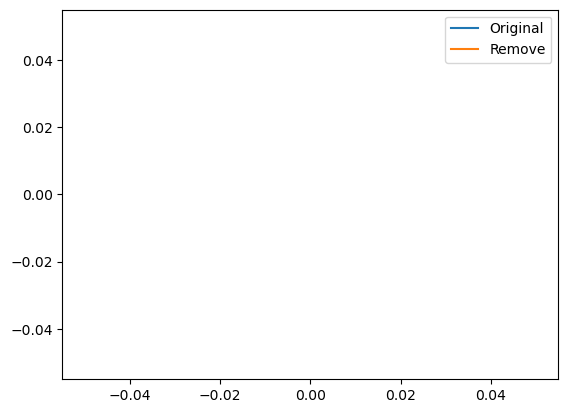

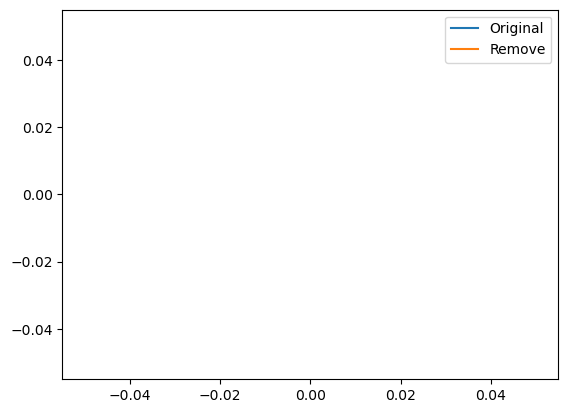

In [40]:
from scipy import signal
from scipy import ndimage

def rotate_longwave_remove(data, cutoffs=[0.01,0.0001], fs=1, order=4, angle=0, nodata=np.nan):
    """
    Rotate data do stripes are horizontal, average signal along rows, 
    low pass filter the average, remove low pass from the average, 
    remove the remaining average from the rows,
    restore the image to its original dimensions.

    Parameters:
    - data: 2D numpy array (input image)
    - cutoff: float (cutoff frequency for low-pass filter)
    - fs: float (sampling frequency for filter)
    - order: int (order of the Butterworth filter)
    - angle: float (rotation angle in degrees)
    - nodata: float or np.nan (value to treat as NoData)

    Returns:
    - unrotated_data: 2D numpy array (filtered image with original dimensions)
    - filt_data: 2D numpy array (intermediate rotated and filtered image)
    """

    # Step 1: Rotate Image
    rotated_data = ndimage.rotate(data, angle=angle, reshape=True, order=1, mode="constant", cval=nodata)
    
    # Replace NoData values with NaN
    rotated_data[rotated_data == nodata] = np.nan
    
    # Step 2: Compute Row-Wise Average
    y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values
    y[np.isnan(y)] = 0

    # Step 3: Apply Low-Pass Filter
    b, a = signal.butter(order, cutoffs, fs=fs, btype='band', analog=False)
    yfilt = signal.filtfilt(b, a, y)
    yfilt[y==0] = np.nan

    # Step 4: Remove Low-Frequency Stripes
    filt_data = rotated_data - (yfilt)[:, None]

    # Step 5: Rotate Back
    unrotated_data = ndimage.rotate(filt_data, angle=-angle, reshape=True, order=1, mode="constant", cval=nodata)

    # Step 6: Crop to Original Size
    center_x, center_y = np.array(unrotated_data.shape) // 2
    orig_x, orig_y = np.array(data.shape) // 2
    cropped_data = unrotated_data[
        center_x - orig_x : center_x + orig_x,
        center_y - orig_y : center_y + orig_y
    ]

    # Step 7: Ensure Final Shape Matches Original
    if cropped_data.shape != data.shape:
        pad_x = max(0, data.shape[0] - cropped_data.shape[0])
        pad_y = max(0, data.shape[1] - cropped_data.shape[1])
        cropped_data = np.pad(cropped_data, ((0, pad_x), (0, pad_y)), mode='constant', constant_values=nodata)

    cropped_data[cropped_data == np.nan] = nodata

    # Step 8: Visualization (Optional)
    x = np.arange(len(y))
    plt.plot(x, y, label='Original')
    plt.plot(x, yfilt, label='Remove')
    plt.legend()
    plt.show()

    return cropped_data# Return both for analysis
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/EWmicmac.tif'
#file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/EWmicmac.tif'
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/EWdispStacked.tif'
im = gdal.Open(file)
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_longwave_remove(imdata,cutoffs=[0.00001,0.0001], fs=1, order=2, angle=0,nodata=-9999)
tt.save_geotiff(destriped,f'{file[:-4]}-dewaved.tif',
                im.GetGeoTransform(),im.GetProjection())

file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/NSmicmac.tif'
#file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mDEM/NSmicmac.tif'
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/NSdispStacked.tif'
im = gdal.Open(file)
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_longwave_remove(imdata,cutoffs=[0.00001,0.0001], fs=1, order=2, angle=0,nodata=-9999)
tt.save_geotiff(destriped,f'{file[:-4]}-dewaved.tif',
                im.GetGeoTransform(),im.GetProjection())

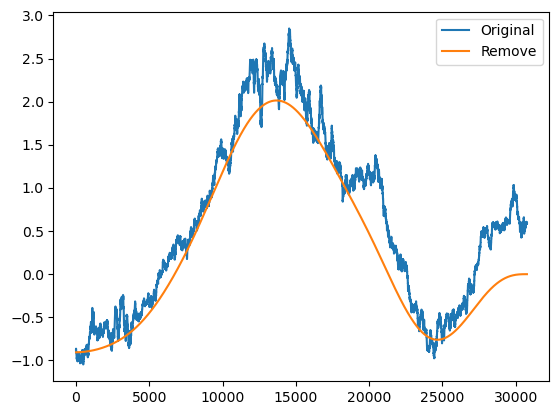

In [39]:
# Step 2: Compute Row-Wise Average
y = np.nanmean(imdata,axis=1)  # Use nanmean to ignore NoData values
y[np.isnan(y)] = 0
# Step 3: Apply Low-Pass Filter
b, a = signal.butter(2, [0.00001,0.0001], fs=1, btype='band', analog=False)
yfilt = signal.filtfilt(b, a, y)
yfilt[y==0] = np.nan
# Step 8: Visualization (Optional)
x = np.arange(len(y))
plt.plot(x, y, label='Original')
plt.plot(x, yfilt, label='Remove')
plt.legend()
plt.show()


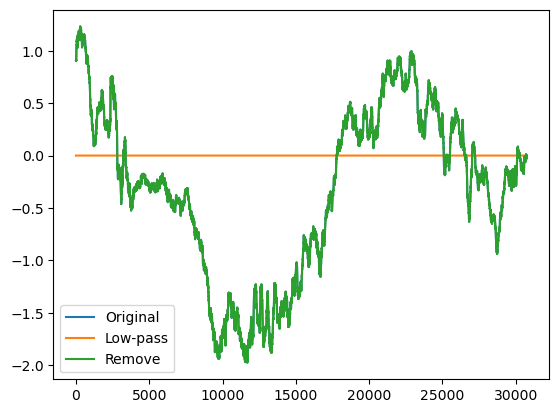

In [16]:
file = '/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Tibet2mWVStereoOrtho/NSmicmac.tif'
im = gdal.Open(file)
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_stripe_remove(imdata, lowpass_filter=False,angle=0,nodata=-9999)
tt.save_geotiff(destriped,f'{file[:-4]}-destriped.tif',
                im.GetGeoTransform(),im.GetProjection())

## Other sections

In [6]:
P = Proj('epsg:32645')
G = Geod(ellps='WGS84')

P(87.3499677, 29.1234285), P(87.6699452,28.3643041)

((534046.3689235895, 3221711.168225529),
 (565648.6703554555, 3137741.617599279))

In [7]:
# Planet Ortho, Analytic MS product
gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250102_042319_67_24b9_3B_AnalyticMS.tif 20250102_042321_66_24b9_3B_AnalyticMS.tif 20250102_042323_66_24b9_3B_AnalyticMS.tif 20250102_042325_65_24b9_3B_AnalyticMS.tif 20250102_042327_64_24b9_3B_AnalyticMS.tif 20250102_042329_63_24b9_3B_AnalyticMS.tif 20250102_042620_89_24ce_3B_AnalyticMS.tif 20250102_042622_89_24ce_3B_AnalyticMS.tif 20250102_042624_88_24ce_3B_AnalyticMS.tif 20250102_042626_88_24ce_3B_AnalyticMS.tif 20250102_042628_88_24ce_3B_AnalyticMS.tif 20250102_042630_87_24ce_3B_AnalyticMS.tif 20250102_050255_04_24e6_3B_AnalyticMS.tif 20250102_050257_28_24e6_3B_AnalyticMS.tif 20250102_050259_53_24e6_3B_AnalyticMS.tif 20250102_050301_77_24e6_3B_AnalyticMS.tif 20250102_050304_02_24e6_3B_AnalyticMS.tif 20250102_050623_76_24f3_3B_AnalyticMS.tif 20250102_050626_00_24f3_3B_AnalyticMS.tif 20250102_050628_24_24f3_3B_AnalyticMS.tif 20250102_050630_48_24f3_3B_AnalyticMS.tif 20250102_050632_71_24f3_3B_AnalyticMS.tif -o 20250102_PlanetMerged_AnalyticMS.tif

gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250106_042304_51_24c4_3B_AnalyticMS.tif 20250106_042306_47_24c4_3B_AnalyticMS.tif 20250106_042308_43_24c4_3B_AnalyticMS.tif 20250106_042310_38_24c4_3B_AnalyticMS.tif 20250106_042312_34_24c4_3B_AnalyticMS.tif 20250106_042826_89_24c8_3B_AnalyticMS.tif 20250106_042828_82_24c8_3B_AnalyticMS.tif 20250106_042830_74_24c8_3B_AnalyticMS.tif 20250106_042832_67_24c8_3B_AnalyticMS.tif 20250106_050200_98_24f6_3B_AnalyticMS.tif 20250106_050203_20_24f6_3B_AnalyticMS.tif 20250106_050205_41_24f6_3B_AnalyticMS.tif 20250106_050207_62_24f6_3B_AnalyticMS.tif -o 20250106_PlanetMerged_AnalyticMS.tif

gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250108_042407_23_24ba_3B_AnalyticMS.tif 20250108_042409_21_24ba_3B_AnalyticMS.tif 20250108_042411_18_24ba_3B_AnalyticMS.tif 20250108_042413_15_24ba_3B_AnalyticMS.tif 20250108_042415_12_24ba_3B_AnalyticMS.tif 20250108_042417_10_24ba_3B_AnalyticMS.tif 20250108_050412_73_24cb_3B_AnalyticMS.tif 20250108_050414_91_24cb_3B_AnalyticMS.tif 20250108_050417_09_24cb_3B_AnalyticMS.tif 20250108_050419_27_24cb_3B_AnalyticMS.tif 20250108_050647_85_2514_3B_AnalyticMS.tif 20250108_050650_17_2514_3B_AnalyticMS.tif 20250108_050652_49_2514_3B_AnalyticMS.tif 20250108_050654_81_2514_3B_AnalyticMS.tif 20250108_050657_13_2514_3B_AnalyticMS.tif -o 20250108_PlanetMerged_AnalyticMS.tif

gdal_merge -ul_lr 534046.3689235895 3221711.168225529 565648.6703554555 3137741.617599279 20250112_042240_69_24b4_3B_AnalyticMS.tif 20250112_042242_67_24b4_3B_AnalyticMS.tif 20250112_042244_64_24b4_3B_AnalyticMS.tif 20250112_042246_61_24b4_3B_AnalyticMS.tif 20250112_042248_58_24b4_3B_AnalyticMS.tif 20250112_042528_40_24c5_3B_AnalyticMS.tif 20250112_042530_34_24c5_3B_AnalyticMS.tif 20250112_042532_29_24c5_3B_AnalyticMS.tif 20250112_042534_23_24c5_3B_AnalyticMS.tif 20250112_050406_90_2500_3B_AnalyticMS.tif 20250112_050409_22_2500_3B_AnalyticMS.tif 20250112_050411_54_2500_3B_AnalyticMS.tif 20250112_050413_86_2500_3B_AnalyticMS.tif 20250112_050416_18_2500_3B_AnalyticMS.tif -o 20250112_PlanetMerged_AnalyticMS.tif

SyntaxError: invalid decimal literal (1542257885.py, line 2)

In [19]:
#!gdalwarp -t_srs EPSG:32645 -srcnodata 0 -dstnodata -9999 -overwrite -te 542631 3152749 559694 3221304 -tr 1 -1 -r near -of GTiff /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/20240116orthomosaic1m.tif /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/mm20240116orthomosaic1m.tif

#!gdalwarp -t_srs EPSG:32645 -srcnodata 0 -dstnodata -9999 -overwrite -te 542631 3152749 559694 3221304 -tr 1 -1 -r near -of GTiff /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/2025multiorthomosaic1m.tif /Volumes/Extreme\ SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/mm2025multiorthomosaic1m.tif

nohup taskset -c 0-64 mm3d Mm2dPosSism mm20240116orthomosaic1m.tif  mm2025multiorthomosaic1m.tif CorMin=0.1 Dequant=false Inc=8 DirMEC='MEC_Tibet1mOrthomosaics/' &




Creating output file that is 17063P x 68555L.
Warning 1: for band 1, destination nodata value has been clamped to 0, the original value being out of range.
Processing /Volumes/Extreme SSD/XizangWVProcessing/MetashapeWV/Orthos1mWith2mDem/2025multiorthomosaic1m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [2]:
import numpy as np

In [10]:
np.arange(3148771.966,3177314.452,5000)

array([3148771.966, 3153771.966, 3158771.966, 3163771.966, 3168771.966,
       3173771.966])

In [13]:
# Stitch together Images 
from osgeo import gdal
rewrite = True
flist = ['/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/25JAN11045451-P1BS-050279139010_01_P001-orthoN.tif',
         '/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/25JAN11045451-P1BS-050279139010_01_P001-orthoS.tif']

ullr = [543725,3175643,559725,3149724] # Upper Left, lower right coordinates
#ullr = [675564-2000, 4035914-2000, 675564+2000, 4035914+2000]

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/Micmac/25JAN11045451meta_mosaic.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=0.48,
    yRes=0.48  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

rewrite = True
flist = ['/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/24JAN16050706-P1BS-050278578010_01_P001-orthoN.tif',
        '/Users/chanagan/Downloads/XizangWVProcessing/Metashape/Orthos/24JAN16050706-P1BS-050278578010_01_P001-orthoS.tif']

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/Micmac/24JAN16050712meta_mosaic.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=0.48,
    yRes=0.48  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

In [ ]:
image_align --alignment-transform rigid 24JAN16050712_mosaic.tif 25JAN11045451_mosaic.tif -o 25JAN11045451_mosaic_aspAligned_topre.tif
nohup taskset -c 0-64 mm3d Mm2dPosSism 24JAN16050712_mosaic.tif 25JAN11045451_mosaic_aspAligned_topre.tif CorMin=0.1 Dequant=false DirMEC='MEC/' &
nohup taskset -c 0-64 mm3d Mm2dPosSism 24JAN16050712meta_mosaic.tif 25JAN11045451meta_mosaic.tif CorMin=0.1 Dequant=false Inc=8 DirMEC='MEC_v1/' &

In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism 2025-01-02_merged_clip.tif 2025-01-08_merged_clip.tif CorMin=0.1 Dequant=false DirMEC='MEC_PlanetOrthoMosaics/' &

In [17]:
# Stitch together Images 
from osgeo import gdal
rewrite = True
flist = ['/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050647_85_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050654_81_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050657_13_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050652_49_2514_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108_050650_17_2514_1B_AnalyticMS-ortho.tif']

ullr = [522544,3209672,569032,3132190] # Upper Left, lower right coordinates
#ullr = [675564-2000, 4035914-2000, 675564+2000, 4035914+2000]

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=3.6,
    yRes=3.6  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

rewrite = True
flist = [
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042327_64_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042321_66_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042323_66_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042319_67_24b9_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102_042325_65_24b9_1B_AnalyticMS-ortho.tif'
]

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged.tif',
    flist,
    srcSRS='EPSG:32645',
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    srcNodata=0,
    dstNodata=0,
    format='GTiff',
    outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=3.6,
    yRes=3.6  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

In [20]:
tt.micmacExport('/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged.tif',
                outname='/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged-Pan.tif')

Computing Gray from RGB values
Writing to /Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250102PlanetMetaMerged-Pan.tif


In [21]:
tt.micmacExport('/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged.tif',
                outname='/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged-Pan.tif')

Computing Gray from RGB values
Writing to /Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250108PlanetMetaMerged-Pan.tif


In [ ]:
nohup taskset -c 0-64 mm3d Mm2dPosSism 20250102PlanetMetaMerged-Pan.tif  20250108PlanetMetaMerged-Pan.tif  CorMin=0.1 Dequant=false DirMEC='MEC_PlanetOrthoMosaics/' &

In [4]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/24JAN16050712meta_mosaic.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/')

Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/NSmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/EWmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_v1_WV/Correlmicmac.tif


## Planet

In [28]:
!ls /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112*tif

/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042240_69_24b4_3B_Visual.tif
/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042242_67_24b4_3B_Visual.tif
/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042244_64_24b4_3B_Visual.tif
/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042246_61_24b4_3B_Visual.tif
/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042248_58_24b4_3B_Visual.tif
/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042528_40_24c5_3B_Visual.tif
/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112_042530_34_24c5

In [ ]:
# order of images matters
flist02 = ['/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042620_89_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042622_89_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042624_88_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042626_88_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042628_88_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042630_87_24ce_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050255_04_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050257_28_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050301_77_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050304_02_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050623_76_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050626_00_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050628_24_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050630_48_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050632_71_24f3_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_050259_53_24e6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042319_67_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042321_66_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042323_66_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042325_65_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042327_64_24b9_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250102_042329_63_24b9_3B_Visual.tif']



flist06 = ['/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042826_89_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042828_82_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042830_74_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042832_67_24c8_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050200_98_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050203_20_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050205_41_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_050207_62_24f6_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042304_51_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042306_47_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042308_43_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042310_38_24c4_3B_Visual.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250106_042312_34_24c4_3B_Visual.tif']

flist08 = ['/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042407_23_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042409_21_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042411_18_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042413_15_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042415_12_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_042417_10_24ba_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050412_73_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050414_91_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050417_09_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050419_27_24cb_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050647_85_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050650_17_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050652_49_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050654_81_2514_3B_Visual.tif', 
'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108_050657_13_2514_3B_Visual.tif']

flist12 = ['/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042240_69_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042242_67_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042244_64_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042246_61_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042248_58_24b4_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042528_40_24c5_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_042530_34_24c5_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050406_90_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050409_22_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050411_54_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050413_86_2500_1B_AnalyticMS-ortho.tif',
'/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/20250112_050416_18_2500_1B_AnalyticMS-ortho.tif']

In [ ]:
rewrite = True

flist = flist02

ullr = [531050, 3213617, 564455, 3141312] # Upper Left, lower right coordinates

if rewrite == True:
    with gdal.Warp(
    f'/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif',
    flist,
    dstSRS='EPSG:32645',
    outputBounds=[ullr[0],ullr[3],ullr[2],ullr[1]],
    #dstNodata=-9999,
    format='GTiff',
    #outputType=gdal.GDT_Int16,
    resampleAlg='bilinear',
    xRes=3,
    yRes=3  # Use a positive value for yRes
    ) as im:
        im.FlushCache()

!gdal_calc.py -R /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif --R_band=1 \
    -G /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif --G_band=2 \
    -B /Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic.tif --B_band=3 \
    --outfile=/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic-gray.tif --calc="R*0.2989+G*0.5870+B*0.1140"



0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
#!/bin/bash
mm3d Mm2dPosSism 20250106PlanetOrthoMosaic-gray.tif 20250112PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_06_12/' Inc=5   
mm3d Mm2dPosSism 20250106PlanetOrthoMosaic-gray.tif 20250108PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_06_08/' Inc=5   
mm3d Mm2dPosSism 20250102PlanetOrthoMosaic-gray.tif 20250112PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_02_12/' Inc=5 
mm3d Mm2dPosSism 20250102PlanetOrthoMosaic-gray.tif 20250108PlanetOrthoMosaic-gray.tif CorMin=0.1 Dequant=false DirMEC='MEC_02_08/' Inc=5 

nohup taskset -c 0-64 ./run.sh &


32.199999999999996

In [36]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/MetashapePlanet/Orthos/Tibet2025_01_08_12_orthomosaic350cm.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/')


Setting nodata value to 0, because reference had no specified value.
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/NSmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/EWmicmac.tif


ERROR 4: /Users/chanagan/Downloads/XizangWVProcessing/Micmac/MEC_PlanetBasicOrthomosaic/Correl_LeChantier_Num_5.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

In [33]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108PlanetOrthoMosaic-gray.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/')


Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/NSmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/EWmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_06_08/Correlmicmac.tif


In [34]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250108PlanetOrthoMosaic-gray.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/')

Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/NSmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/EWmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_08/Correlmicmac.tif


In [35]:
tt.micmacPostProcessing(folder='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/',
                         prefile='/Users/chanagan/Downloads/XizangWVProcessing/PlanetOrthos/Planet2pre2postXizang2025_psscene_visual/PSScene/20250112PlanetOrthoMosaic-gray.tif',
                         outprefix='/Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/')

Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/NSmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/EWmicmac.tif
Saving /Users/chanagan/Downloads/XizangWVProcessing/Micmac/PlanetLargeRegionStack/MEC_02_12/Correlmicmac.tif


## Polynomial fit

In [9]:
# Standard Imports
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
from scipy import signal
from scipy.signal import butter, filtfilt
from skimage.restoration import denoise_bilateral

import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt




In [10]:
im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
denoised = denoise_bilateral(imdata, sigma_color=None, sigma_spatial=8, bins=10000, mode='edge')

In [11]:
tt.save_geotiff(denoised,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-denoised.tif',
                im.GetGeoTransform(),im.GetProjection())

/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_44689/3072999775.py:28: RuntimeWarning: Mean of empty slice
  y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values


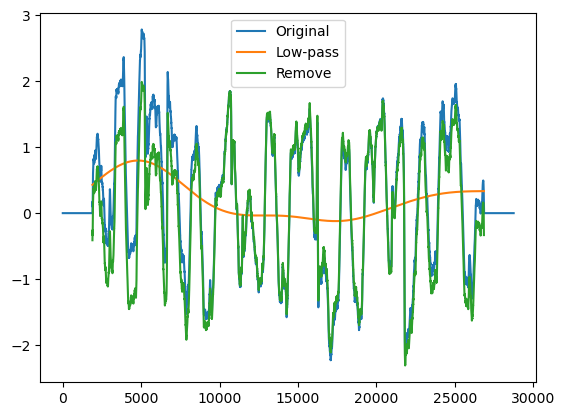

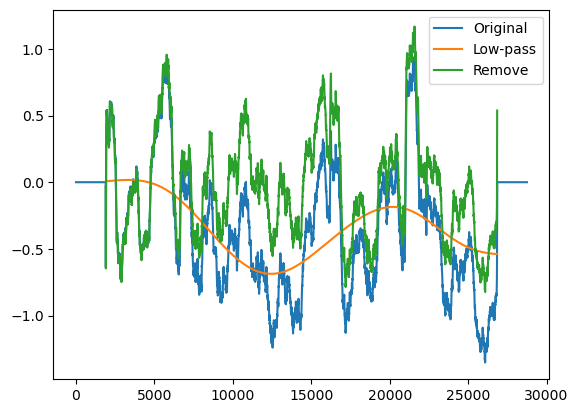

In [10]:
def rotate_stripe_remove(data, cutoff, fs, order=4, angle=0, nodata=np.nan):
    """
    Rotate data do stripes are horizontal, average signal along rows, 
    low pass filter the average, remove low pass from the average, 
    remove the remaining average from the rows,
    restore the image to its original dimensions.

    Parameters:
    - data: 2D numpy array (input image)
    - cutoff: float (cutoff frequency for low-pass filter)
    - fs: float (sampling frequency for filter)
    - order: int (order of the Butterworth filter)
    - angle: float (rotation angle in degrees)
    - nodata: float or np.nan (value to treat as NoData)

    Returns:
    - unrotated_data: 2D numpy array (filtered image with original dimensions)
    - filt_data: 2D numpy array (intermediate rotated and filtered image)
    """

    # Step 1: Rotate Image
    rotated_data = ndimage.rotate(data, angle=angle, reshape=True, order=1, mode="constant", cval=nodata)
    
    # Replace NoData values with NaN
    rotated_data[rotated_data == nodata] = np.nan
    
    # Step 2: Compute Row-Wise Average
    y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values
    y[np.isnan(y)] = 0

    # Step 3: Apply Low-Pass Filter
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    yfilt = filtfilt(b, a, y)
    yfilt[y==0] = np.nan

    # Step 4: Remove Low-Frequency Stripes
    filt_data = rotated_data - (y - yfilt)[:, None]

    # Step 5: Rotate Back
    unrotated_data = ndimage.rotate(filt_data, angle=-angle, reshape=True, order=1, mode="constant", cval=nodata)

    # Step 6: Crop to Original Size
    center_x, center_y = np.array(unrotated_data.shape) // 2
    orig_x, orig_y = np.array(data.shape) // 2
    cropped_data = unrotated_data[
        center_x - orig_x : center_x + orig_x,
        center_y - orig_y : center_y + orig_y
    ]

    # Step 7: Ensure Final Shape Matches Original
    if cropped_data.shape != data.shape:
        pad_x = max(0, data.shape[0] - cropped_data.shape[0])
        pad_y = max(0, data.shape[1] - cropped_data.shape[1])
        cropped_data = np.pad(cropped_data, ((0, pad_x), (0, pad_y)), mode='constant', constant_values=nodata)

    cropped_data[cropped_data == np.nan] = nodata

    # Step 8: Visualization (Optional)
    x = np.arange(len(y))
    plt.plot(x, y, label='Original')
    plt.plot(x, yfilt, label='Low-pass')
    plt.plot(x, y - yfilt, label='Remove')
    plt.legend()
    plt.show()

    return cropped_data# Return both for analysis

im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_stripe_remove(imdata, cutoff=0.0001, fs=1, order=4,angle=11.5,nodata=0)
#tt.save_geotiff(destriped,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif',
#                im.GetGeoTransform(),im.GetProjection())

im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
destriped = rotate_stripe_remove(imdata, cutoff=0.0001, fs=1, order=4,angle=11.5,nodata=0)
#tt.save_geotiff(destriped,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif',
#                im.GetGeoTransform(),im.GetProjection())

In [7]:
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileN.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileC.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileS.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE.tif

!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileN.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileC.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE.tif
!gdalwarp -overwrite -of GTiff -cutline /Volumes/Extreme\ SSD/XizangWVProcessing/GIS/PlanetTileS.shp -crop_to_cutline /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5.tif /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE.tif

Creating output file that is 11452P x 11320L.
Using internal nodata values (e.g. -9999) for image /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif.
Copying nodata values from source /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif to destination /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE.tif.
Processing /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11447P x 11290L.
Using internal nodata values (e.g. -9999) for image /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5.tif.
Copying nodata values from source /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_Planet

In [8]:
import numpy as np
from scipy.optimize import curve_fit

def polynomial_surface(xy, a, b, c, d, e, f):
    """2D quadratic polynomial function."""
    x, y = xy
    return a*x + b*y + c*x*y + d*x**2 + e*y**2 + f

def process_valid_data(image, nodata_value=np.nan):
    """Processes displacement data while ignoring boundary NoData values and returns the ramp."""
    image[image == nodata_value] = np.nan
    ny, nx = image.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))

    # Mask NoData values
    fmask = np.isfinite(image)
    valid_x, valid_y, valid_z = x[fmask], y[fmask], image[fmask]

    # Fit polynomial to valid data only (example: deramping)
    popt, _ = curve_fit(polynomial_surface, (valid_x, valid_y), valid_z)

    # Compute ramp over the entire grid
    ramp = polynomial_surface((x, y), *popt)

    # Remove ramp from valid data
    processed_data = np.full_like(image, np.nan)  # Start with NoData everywhere
    processed_data[fmask] = valid_z - polynomial_surface((valid_x, valid_y), *popt)  # Apply only to valid pixels

    # Preserve NoData values in the ramp where original image had NoData
    ramp[~fmask] = nodata_value

    return processed_data, ramp


# Apply to all tiles:
imlist = [
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE.tif',
'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE.tif'
]
for imf in imlist:
    im = gdal.Open(imf)
    data = im.GetRasterBand(1).ReadAsArray()
    processed_displacement, ramp = process_valid_data(data, nodata_value=-9999)
    f = imf[:-4]+'_deramped.tif'
    print('saving',f)
    tt.save_geotiff(processed_displacement,f,im.GetGeoTransform(),im.GetProjection())
    


saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE_deramped.tif
saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE_deramped.tif
saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE_deramped.tif
saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE_deramped.tif
saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE_deramped.tif
saving /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE_deramped.tif


In [2]:
!gdalwarp -tr 0.5 0.5 -overwrite -r bilinear -srcnodata -9999 -dstnodata -9999 -ot Float32 -of GTiff -co COMPRESS=LZW -co BIGTIFF=YES \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_deramped.tif

!gdalwarp -tr 0.5 0.5 -overwrite -r bilinear -srcnodata -9999 -dstnodata -9999 -ot Float32 -of GTiff -co COMPRESS=LZW -co BIGTIFF=YES \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_NTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_CTILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_STILE_deramped.tif \
    /Volumes/Extreme\ SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac-destriped11.5_deramped.tif


Creating output file that is 87342P x 158208L.
ERROR 4: Unable to open /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_deramped.tif to obtain file list.
Processing /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_NTILE_deramped.tif [1/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_CTILE_deramped.tif [2/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08EWmicmac-destriped11.5_STILE_deramped.tif [3/3] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 87342P x 158208L.
Processing /Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac

OSError: [Errno 5] Input/output error

Text(0.5, 1.0, 'Residual')

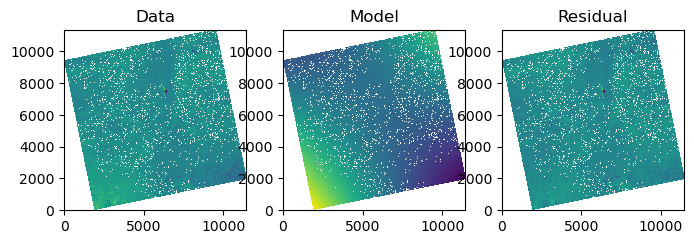

In [4]:
# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(data, origin='lower', interpolation='nearest')
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(ramp, origin='lower', interpolation='nearest')
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(data-ramp, origin='lower', interpolation='nearest')
plt.title("Residual")

In [11]:
tt.save_geotiff(data-ramp,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/destripe_11.5_EWmicmac_N_deramped.tif',
                im.GetGeoTransform(),im.GetProjection())

In [2]:
im = gdal.Open('/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac.tif')
imdata = im.GetRasterBand(1).ReadAsArray()
shape = imdata.shape


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_2445/2628601324.py:28: RuntimeWarning: Mean of empty slice
  y = np.nanmean(rotated_data,axis=1)  # Use nanmean to ignore NoData values


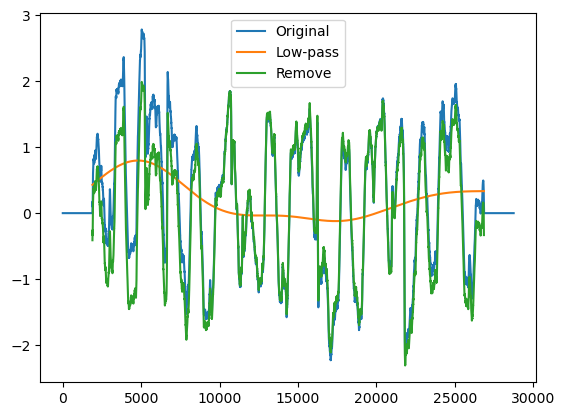

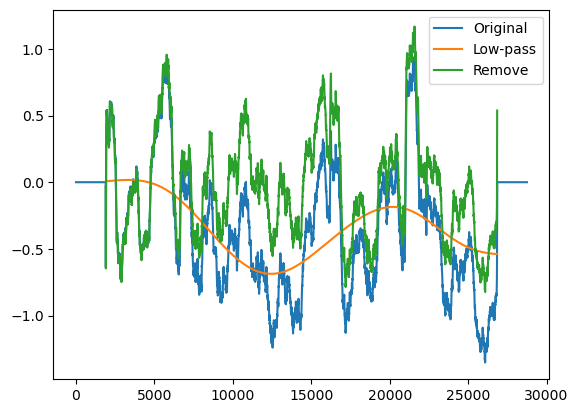

In [43]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.fft import fft2, ifft2

import numpy as np
from scipy.optimize import curve_fit
from scipy.fft import fft2, ifft2

def bandpass_filter(image, low_freq=0.0008, high_freq=1, nodata_value=np.nan):
    """Applies a bandpass filter to remove striping while preserving NoData values."""
    ny, nx = image.shape  # Get correct dimensions
    
    # Generate frequency grids with correct shape
    fx = np.fft.fftfreq(nx)  # Shape: (nx,)
    fy = np.fft.fftfreq(ny)  # Shape: (ny,)

    # Create 2D frequency meshgrid with proper shape
    FX, FY = np.meshgrid(fx, fy, indexing='xy')  # Now FX and FY are (ny, nx)

    freq_radius = np.sqrt(FX**2 + FY**2)  # Frequency magnitude, shape (ny, nx)

    # Bandpass mask
    bandpass_mask = (freq_radius >= low_freq) & (freq_radius <= high_freq)
    
    # Apply FFT only to valid data
    mask = np.isfinite(image)
    image_filled = np.where(mask, image, np.nanmedian(image[mask]))  # Fill NaNs with median
    fft_image = fft2(image_filled)  # Shape should be (ny, nx)

    # Debugging: Print shapes before multiplication
    print(f"fft_image shape: {fft_image.shape}, bandpass_mask shape: {bandpass_mask.shape}")

    # Apply the filter correctly
    fft_image_filtered = fft_image * bandpass_mask  # Ensure matching shapes

    # Inverse FFT
    filtered_image = np.real(ifft2(fft_image_filtered))

    # Restore NoData values
    filtered_image[~mask] = nodata_value
    return filtered_image


def polynomial_surface(xy, a, b, c, d, e, f):
    """2D quadratic polynomial function for ramp fitting."""
    x, y = xy
    return a*x + b*y + c*x*y + d*x**2 + e*y**2 + f

def process_valid_data(image, nodata_value=np.nan):
    """Applies bandpass filtering, removes the ramp, and returns processed data + ramp."""
    ny, nx = image.shape
    x_coords, y_coords = np.meshgrid(np.arange(nx), np.arange(ny), indexing='xy')  # Fix grid shape

    # Step 1: Bandpass filter the image
    filtered_image = bandpass_filter(image, nodata_value=nodata_value)

    # Step 2: Fit and remove ramp
    mask = np.isfinite(filtered_image)  # True for valid pixels
    valid_x, valid_y, valid_z = x_coords[mask], y_coords[mask], filtered_image[mask]

    popt, _ = curve_fit(polynomial_surface, (valid_x, valid_y), valid_z)

    # Compute ramp
    ramp = polynomial_surface((x_coords, y_coords), *popt)

    # Remove ramp from valid data
    processed_data = np.full_like(image, nodata_value)
    processed_data[mask] = valid_z - polynomial_surface((valid_x, valid_y), *popt)

    # Preserve NoData values in the ramp
    ramp[~mask] = nodata_value

    return processed_data, ramp, filtered_image

# Example usage
data = imdata.copy()
data[data == 0] = np.nan


#processed_displacement, estimated_ramp, filtered_image = process_valid_data(data, nodata_value=np.nan)


In [44]:
filtered_image = bandpass_filter(data, nodata_value=np.nan)


fft_image shape: (26372, 14566), bandpass_mask shape: (26372, 14566)


In [50]:
tt.save_geotiff(filtered_image,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac_bandpassed.tif',
                im.GetGeoTransform(),im.GetProjection())

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

def directional_fft_filter(image, angle_deg, width=0.05, plot_spectrum=False):
    """
    Removes periodic noise (sine/cosine waves) in a specific direction using FFT filtering.

    Parameters:
    - image (np.ndarray): 2D input array (NaNs are treated as missing values).
    - angle_deg (float): Angle (in degrees) of the dominant stripe/noise direction.
    - width (float): Bandwidth around the angle to remove (normalized frequency range).
    - plot_spectrum (bool): If True, plots FFT spectrum before/after filtering.

    Returns:
    - filtered_image (np.ndarray): The filtered image.
    - applied_filter (np.ndarray): The filter mask used in the frequency domain.
    """

    # Handle NaNs: Replace with median of valid pixels
    mask = np.isnan(image)
    image_filled = np.where(mask, np.nanmedian(image[~mask]), image)

    # Get image dimensions
    m, n = image.shape
    u, v = np.meshgrid(np.fft.fftfreq(n), np.fft.fftfreq(m))  # Frequency grid
    d = np.sqrt(u**2 + v**2)  # Distance in frequency domain

    # Convert angle to radians
    theta = np.deg2rad(angle_deg)

    # Compute frequency components in the given direction
    freq_angle = np.arctan2(v, u)

    # Directional Band-Stop Filter
    filter_mask = np.ones_like(d)
    angle_diff = np.abs(freq_angle - theta)
    
    # Create a notch filter that removes frequencies in a narrow range
    filter_mask[(angle_diff < width) | (angle_diff > (np.pi - width))] = 0

    # Apply FFT
    F = fft2(image_filled)
    F_shifted = fftshift(F)

    # Apply directional filter
    F_filtered = F_shifted * filter_mask

    # Inverse FFT to get back to spatial domain
    filtered_image = np.real(ifft2(ifftshift(F_filtered)))

    # Restore NaN regions
    filtered_image[mask] = np.nan

    # Plot FFT spectrum if requested
    if plot_spectrum:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.log1p(np.abs(F_shifted)), cmap='gray')
        plt.title("Original FFT Spectrum")

        plt.subplot(1, 2, 2)
        plt.imshow(np.log1p(np.abs(F_filtered)), cmap='gray')
        plt.title("Filtered FFT Spectrum")
        plt.show()

    return filtered_image, filter_mask


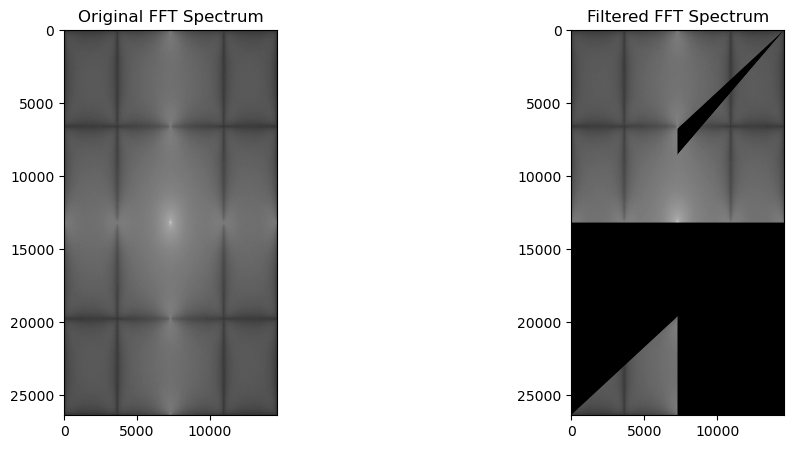

In [51]:
filtered_image, filter_mask = directional_fft_filter(data, 150, width=0.05, plot_spectrum=True)

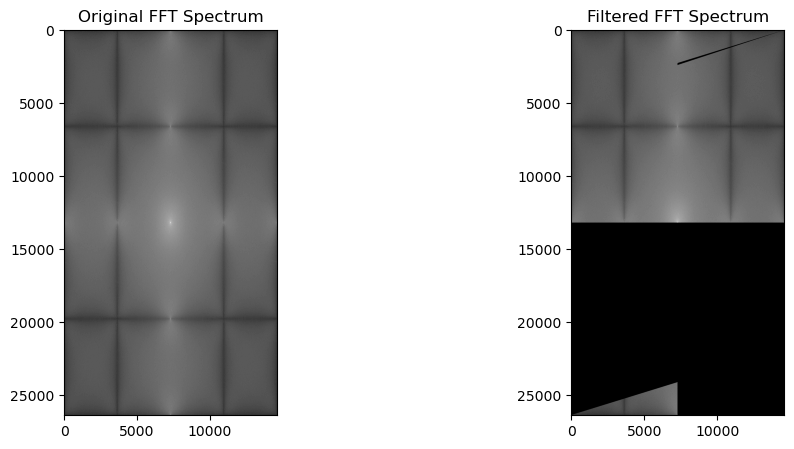

In [56]:
filtered_image, filter_mask = directional_fft_filter(data, 170, width=0.005, plot_spectrum=True)

In [57]:
tt.save_geotiff(filtered_image,'/Volumes/Extreme SSD/XizangWVProcessing/Micmac/MEC_PlanetOrthoMosaics/Planet20250102to08NSmicmac_bandpassed.tif',
                im.GetGeoTransform(),im.GetProjection())